In [99]:
### Old working code

import numpy as np
import dask.array as da
import xarray as xr
import pandas as pd
from PIL import Image
import random
from dask import delayed, compute
from tqdm import tqdm

class ImageProcessor:
    """Image generation class
    """    
    
    def __init__(self, 
                 num_to_generate,
                 tiff_path, 
                 dark_noise_path, 
                 canvas_size = (64, 64), 
                 max_electron_hits = 410):
        """initializes the ImageProcessor class

        Args:
            tiff_path (filepath): Location of the tiff file that contains the electron hits
            dark_noise_path (filepath): path to the noisy data
        """        
        
        self.tiff_path = tiff_path
        self.dark_noise_path = dark_noise_path
        self.images = self.load_images_from_tiff(tiff_path)
        self.dark_noise_images = self.load_images_from_tiff(dark_noise_path)
        self.canvas_size = canvas_size
        self.dark_noise = self.dark_stack(self.canvas_size[0])  # Ensure dark stack matches the canvas size
        self.num_to_generate = num_to_generate
        self.max_electron_hits = max_electron_hits

    def load_images_from_tiff(self, tiff_path):
        with Image.open(tiff_path) as img:
            images = []
            for i in range(img.n_frames):
                img.seek(i)
                images.append(np.array(img))
            return images
        
    def noisy(self, noise_typ, image): 
        """Adds noise to the images
        """
        if noise_typ == "gauss":
            row, col = image.shape
            mean = 0
            var = 0.0001
            sigma = var**0.5
            threshold = 8
            gauss = np.random.normal(mean, sigma, (row, col))
            tnoisy = image + gauss

            tnoisy[tnoisy < threshold] = 0
            noisy = np.round(tnoisy)
            return noisy

    def deadcorr(self, image):
        '''
        This function corrects the dead pixel within the dark reference frame.
        Works for current dead pixel correction, interpolating from near positions.
        '''
        temp = image.copy()
        temp[:, 248] = 0.5 * temp[:, 247] + 0.5 * temp[:, 246]
        return temp

    def dark_stack(self, imgsize):
        dark_noise_stack_corrected = [self.deadcorr(image) for image in self.dark_noise_images]
        # Crop images to the specified size around the center
        dark_noise_stack_cropped = [image[512:512+imgsize, 512:512+imgsize] for image in dark_noise_stack_corrected]
        return dark_noise_stack_cropped

    def place_image_on_canvas(self, canvas, dark_noise, positions):
        
        height, width = image.shape
        for _ in range(positions):
            max_x = self.canvas_size[1] - width
            max_y = self.canvas_size[0] - height
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)
            
            if not np.any(canvas[y:y+height, x:x+width]):
            
                canvas[y:y+height, x:x+width] = image
                
                # gaussian noise
                canvas = self.noisy('gauss', canvas)
                
                # selects a random integer from the dark stack
                noise_int = np.random.randint(len(dark_noise))
                
                canvas = canvas + dark_noise[noise_int]
                
                bounding_box = (x, y, x+width, y+height)
                
                center = (x + width // 2, y + height // 2)
                return bounding_box, center

    def create_image_with_random_placements(self, positions):
        canvas = np.zeros(self.canvas_size, dtype=np.uint8)

        results = self.place_image_on_canvas(canvas, self.dark_noise, positions)
        
        bounding_boxes = []
        centers = []
        num_images_placed = 0

        for result in results:
            if result[0] is not None:
                bounding_boxes.append(result[0])
                centers.append(result[1])
        
        num_images_placed = len(bounding_boxes) + 1
        
        # Convert lists to NumPy arrays for storing as attributes
        bounding_boxes = np.array(bounding_boxes)
        centers = np.array(centers)
        
        return (canvas, bounding_boxes, centers, num_images_placed)

    def generate_multiple_images(self):
        
        # Preallocate a 3D xarray for all images
        all_canvases = xr.DataArray(np.zeros((self.num_to_generate, *self.canvas_size), dtype=np.uint8), 
                                    dims=('image', 'y', 'x'))
        
        bounding_boxes_list = []
        centers_list = []
        num_images_placed_list = []

        for i in tqdm(range(self.num_to_generate), desc="Generating images"):
            positions = random.randint(1, self.max_electron_hits)
            canvas_da = self.create_image_with_random_placements(self.num_to_generate, positions)
            all_canvases[i, :, :] = canvas_da
            bounding_boxes_list.append(canvas_da.attrs['bounding_boxes'])
            centers_list.append(canvas_da.attrs['centers'])
            num_images_placed_list.append(canvas_da.attrs['num_images_placed'])

        # Add metadata to the xarray
        all_canvases.attrs['bounding_boxes'] = bounding_boxes_list
        all_canvases.attrs['centers'] = centers_list
        all_canvases.attrs['num_images_placed'] = num_images_placed_list

        return all_canvases
    
    def save_to_file(self, results, filename):
        """Saves the generated images to a NetCDF file
        
        Args:
            results (list): List of xarray DataArrays containing the generated images
            filename (str): Path to the output file
        """
        dataset = xr.Dataset()
        for i, canvas_da in enumerate(results):
            dataset[f'image_{i}'] = canvas_da
        dataset.to_netcdf(filename)
        print(f'Saved results to {filename}')

# Example usage
tiff_path = './data/200kV_98000electron.tif'
dark_noise_path = './data/1000fps_fullRolling.tif'

processor = ImageProcessor(100, tiff_path, dark_noise_path)

images_list = processor.generate_multiple_images()

processor.save_to_file(images_list, 'output.nc')

# Access the metadata for the first image
canvas_da = images_list[0]
bounding_boxes = canvas_da.attrs['bounding_boxes']
centers = canvas_da.attrs['centers']
num_images_placed = canvas_da.attrs['num_images_placed']


2024-05-19 16:38:32,863 - distributed.worker - WARNING - Compute Failed
Key:       create_image_with_random_placements-e99a5bce-c2c4-40c4-ad95-7f277348db00
Function:  create_image_with_random_placements
args:      (<__main__.ImageProcessor object at 0x7fdd4a39b590>, 310)
kwargs:    {}
Exception: 'Exception(\'Long error message\', "Tried sending message after closing.  Status: closed\\nMessage: {\'op\': \'update-graph\', \'graph_header\': {\'serializer\': \'pickle\', \'writeable\': (True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [93]:
np.savez('images_list.npz', images_list=images_list)

In [14]:
# Load the image stack of single event
raw = load_images_from_tiff('./data/200kV_98000electron.tif')

/home/ferroelectric/micromamba/envs/electroncounting/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [40]:
dark_noise_path = './data/1000fps_fullRolling.tif'

dark_noise = load_images_from_tiff(dark_noise_path)

dark_stack = dark_stack(dark_noise_path, 64)

In [92]:
results = images_list
dataset = xr.Dataset()
for i, canvas_da in enumerate(results):
    dataset[f'image_{i}'] = canvas_da
dataset.to_netcdf(filename)
print(f'Saved results to {filename}')

ValueError: netCDF attributes must be 1-dimensional

In [90]:
results = images_list
filename = 'results.nc'

images_list.to_netcdf(filename)
print(f'Saved results to {filename}')

AttributeError: 'list' object has no attribute 'to_netcdf'

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

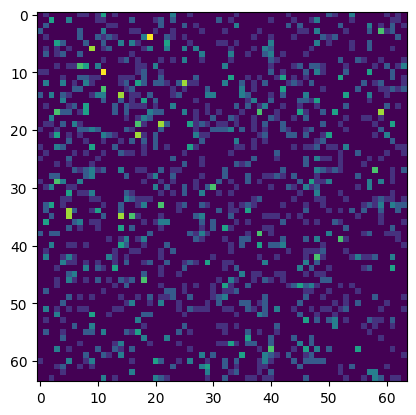

In [41]:
import matplotlib.pyplot as plt

plt.imshow(dark_stack[0])
plt.colorbar

# Data Preparation

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os

## load data

In [5]:
# Load the image stack of single event
raw = Image.open('./data/200kV_98000electron.tif')

# dark noise added from a exp dark frame
dark = Image.open()

In [6]:
from PIL import Image
import numpy as np
import xarray as xr

def tiff_to_xarray(image_path):
    with Image.open(image_path) as img:
        frames = []
        frame_count = 0
        try:
            while True:
                img.seek(frame_count)
                frames.append(np.array(img))
                frame_count += 1
        except EOFError:
            pass
        
    # Convert the list of frames to a numpy array
    frames_array = np.stack(frames, axis=0)

    # Create xarray DataArray
    data_array = xr.DataArray(
        frames_array,
        dims=["frame", "y", "x"],
        coords={"frame": np.arange(frames_array.shape[0])}
    )

    return data_array

In [7]:
# Load the image stack of single event
raw = tiff_to_xarray('./data/200kV_98000electron.tif')

In [21]:
imgsize = 64
sparsity = .1
max_count = 410

# gets the number of frames in the stack
w = raw['frame'].shape[0]

wh = int((w-1)/2)

# should just have a max value of electrons
count = np.random.randint(0,max_count)

posx = np.random.randint(0, imgsize, size=count)
posy = np.random.randint(0, imgsize, size=count)

# should make a vector that tracks if a spot is there.
# groundtruth = np.zeros((imgsize,imgsize))
# for i in range(len(posx)):
#     groundtruth[posx[i],posy[i]] += 1

TypeError: object of type 'TiffImageFile' has no len()

In [ ]:
# def randomtile(rawimagestack, sparsity, returnBoxMask = False, imgsize= 64):
#   '''
#   This function create images with random electron event distribution.
#   sparsity: # e-/px
#   imgsize: the size of output images.
#   '''
#   rawimagestack.seek(0)
#   w = np.asarray(rawimagestack).shape[0]
#   wh = int((w-1)/2)

#   count = int(np.ceil(imgsize*imgsize*sparsity))# number of electrons in a image
#   #print('Electons: ', count)
#   posx = np.random.randint(0,imgsize,size=count)
#   posy = np.random.randint(0,imgsize,size=count)

  # groundtruth = np.zeros((imgsize,imgsize))
  # for i in range(len(posx)):
  #   groundtruth[posx[i],posy[i]] += 1

  tileimage = np.zeros((imgsize+w-1,imgsize+w-1))
  # masks = np.zeros((len(posx), 15,15))
  boxes = np.zeros((len(posx), 4))

  for patch in range(len(posx)):
    index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
    rawimagestack.seek(index)
    rawdata = np.asarray(rawimagestack)
    while rawdata.max()<=20:
      index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
      rawimagestack.seek(index)
      rawdata = np.asarray(rawimagestack)

    rawdata = np.clip(rawdata, a_min=0, a_max = None)

    tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] + rawdata
    if returnBoxMask==True:
      #masks[patch][posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = rawdata>20  # threshold is set to 20.
      x, y = np.where(rawdata>20)
      # masks[patch][:(1+x.max()-x.min()), :(1+y.max()-y.min())] = rawdata[x.min():(x.max()+1), y.min():(y.max()+1)]>0
      boxes[patch] = (x.min()+posx[patch]-wh, y.min()+posy[patch]-wh,
                      x.max()+posx[patch]-wh, y.max()+posy[patch]-wh)

  if returnBoxMask==True:
      return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh],boxes
  else:
    return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh]

In [ ]:
def generate_images(filenumber, image_size):
    

# Random tile for training data generation

In [ ]:


# filenumber = 0
# imgsize = 64 ########
# for sparsity in np.linspace(0, 0.1,51):

#   # slist = np.linspace(sparsity, sparsity + 0.002, 11)[1:]
#   # repeat = 20 ######### defines how many images will be generated within this sparisity range
#   truth_all = np.zeros((10,repeat,imgsize,imgsize))
#   tiled_all = np.zeros((10,repeat,imgsize,imgsize))

#   imgfiles = []
#   boxfiles = []

  # # dark noise added from a exp dark frame
  # dark = Image.open('/content/drive/MyDrive/CNN e-detect for Celeritas/Black noise/1000fps_fullRolling.tif')

  for i in range(len(slist)):
    for rp in range(repeat):
      _, img, boxes = randomtile(rawimagestack = raw, sparsity = slist[i], returnBoxMask=True, imgsize= 64)

      # gaussian noise
      img = noisy('gauss',img)
      # dark noise
      frame = np.random.randint(0,10)
      dark.seek(frame)
      rawdata = np.array(dark) # the only way to make the data writable
      source = deadcorr(rawdata)
      random.shuffle(source)

      img = img + source[512:512+imgsize, 512:512+imgsize]
      imgfiles.append(img)
      boxfiles.append(boxes)
  path = '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/' ##########
  np.savez(path+ f"{filenumber:03}" +'_img.npz',*imgfiles)
  np.savez(path+ f"{filenumber:03}" +'_box.npz',*boxfiles)

  print('Done stack,', filenumber)
  filenumber = filenumber + 1


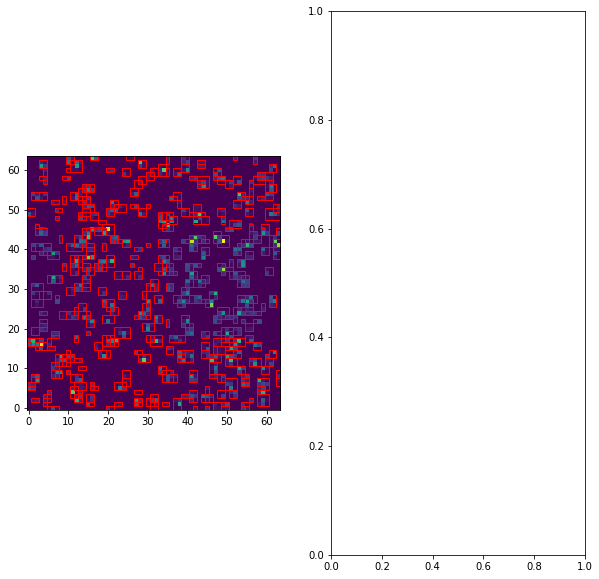

In [ ]:
import matplotlib.patches as patches
img = np.load(path+ f"{(filenumber-1):03}" +'_img.npz')
box = np.load(path+ f"{(filenumber-1):03}" +'_box.npz')

fig =  plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(img['arr_100'], origin='lower')
for box in box['arr_100']:
  ymin, xmin, ymax, xmax = box
  rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin+1, ymax - ymin+1, linewidth=1, edgecolor='r',
                            facecolor='none')
  ax1.add_patch(rect)

# ax2.imshow(truth_all, origin='lower')
# for box in boxall:
#   ymin, xmin, ymax, xmax = box
#   ymax = ymax+1
#   xmax = xmax+1
#   ymin, xmin, ymax, xmax = ymin*2, xmin*2, ymax*2, xmax*2
#   rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r',
#                             facecolor='none')
#   ax2.add_patch(rect)
plt.show()


Mostly, Sparsity>= 0.05 max count = 3

0.02>Sparsity>= 0.002 max count = 2

Sparsity < 0.002 max count = 1

# AUX functions


In [ ]:
def noisy(noise_typ,image): #defining a function to add noise to the images
   if noise_typ == "gauss":
      row,col,= image.shape
      mean = 0             #taken from sparse frames of celeritas histogram . mean = -0.17  .RMSD = 1.319
      var = 0.0001           #square of the standard deviation from sparse frames histogram
      sigma = var**0.5
      threshold = 8 #8ADU
      gauss = np.random.normal(mean,sigma,(row,col))     #thresholding instead of adding noise
      tnoisy = image + gauss                            #just making sure they're not exactly the same

      for x in range(row):                    #Noise thresholding so that only positive noise is added to the empty pixels
             for y in range(col):
                                                #each pixel should be an integer, not a floating point. Round each pixel after noise is added.
                 if tnoisy[x][y] < threshold:      #trying not to wipe out smaller contributions
                     tnoisy[x][y] = 0

      noisy = np.round(tnoisy) #+ gauss)    #adding noise after thresholding to recreate the image
      return noisy

In [ ]:
def deadcorr(raw):
  '''
  This function corrects the dead pixel within the dark reference frame.
  work for current dead pixel correction, interpolate from near position
  '''
  temp = raw
  temp[:,248] = 0.5*temp[:,247] + 0.5*temp[:,246]
  return temp